Loaded signal 'EEG Fp1-REF' with 3603000 samples at 500.0 Hz.
Total data points per channel: 3603000.0
Start: 0, Stop: 3603000, Sample Amount: 500
7206


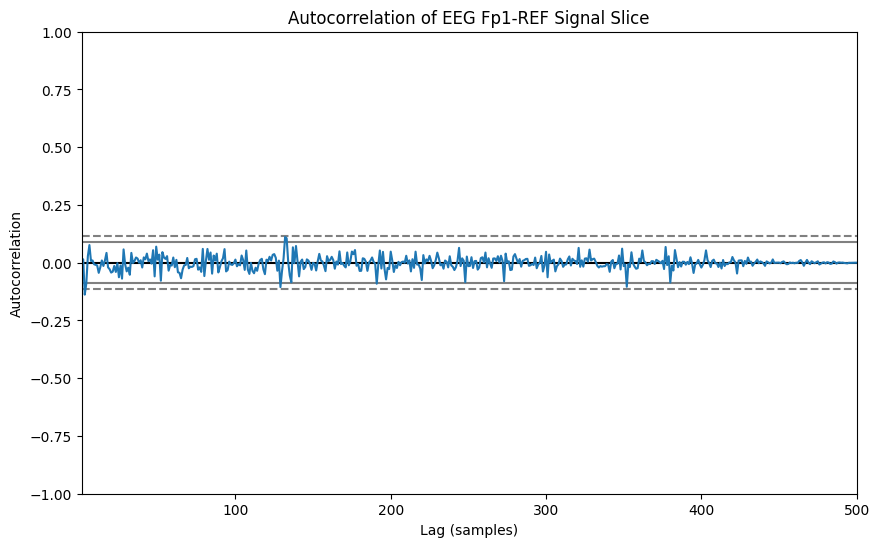

(np.float64(-13.339552574718835), np.float64(5.957894216199126e-25), 3, 496, {'1%': np.float64(-3.4436029548776395), '5%': np.float64(-2.867384756137026), '10%': np.float64(-2.5698830308597813)}, np.float64(6371.008785025258))
ADF Statistic: -13.339552574718835
p-value: 5.957894216199126e-25
The time series is stationary (reject null hypothesis).


In [ ]:
import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# Set plotting style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
import math
import numpy as np
def read_eeg_data(file_path):
    """Reads an EDF file and returns signal data and metadata."""
    with pyedflib.EdfReader(file_path) as f:
        # Get all signals and metadata
        signal_labels = f.getSignalLabels()
        sample_rate = f.getSampleFrequency(0)
        signals = [f.readSignal(i) for i in range(len(signal_labels))]
        duration = f.getFileDuration()

    return signals, signal_labels, sample_rate, duration

path = "seizure_eeg_data/01.edf"
all_signals, signal_labels, sample_rate, duration = read_eeg_data(path)
# 20k samples
sample_amount = 500

signal_one = all_signals[0]
print(f"Loaded signal '{signal_labels[0]}' with {len(signal_one)} samples at {sample_rate} Hz.")
data_points_per_channel = duration * sample_rate
print(f"Total data points per channel: {data_points_per_channel}")
start = 0
stop = int(data_points_per_channel / sample_rate) * 500 # 500 seconds
print(f"Start: {start}, Stop: {stop}, Sample Amount: {sample_amount}")
step = int(stop / sample_amount)
print(step)
signal_slice = signal_one[start:stop:step]

axes = pd.plotting.autocorrelation_plot(signal_slice)
axes.set_title(f"Autocorrelation of {signal_labels[0]} Signal Slice")
plt.xlabel("Lag (samples)")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

adf_result = adfuller(signal_slice)
print(adf_result)
print(f"ADF Statistic: {adf_result[0]}")
print('p-value: %s' % adf_result[1])
if adf_result[1] < 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")




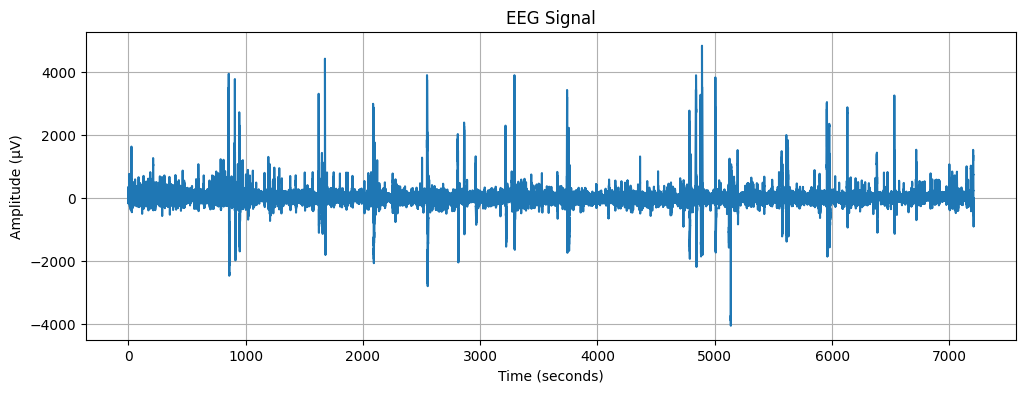

In [2]:
from statsmodels.graphics.tsaplots import plot_acf

time_axis_600s = np.arange(signal_one.shape[0]) / sample_rate

plt.figure(figsize=(12, 4))
plt.plot(time_axis_600s, signal_one, label='EEG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title('EEG Signal')
plt.grid()
plt.show()



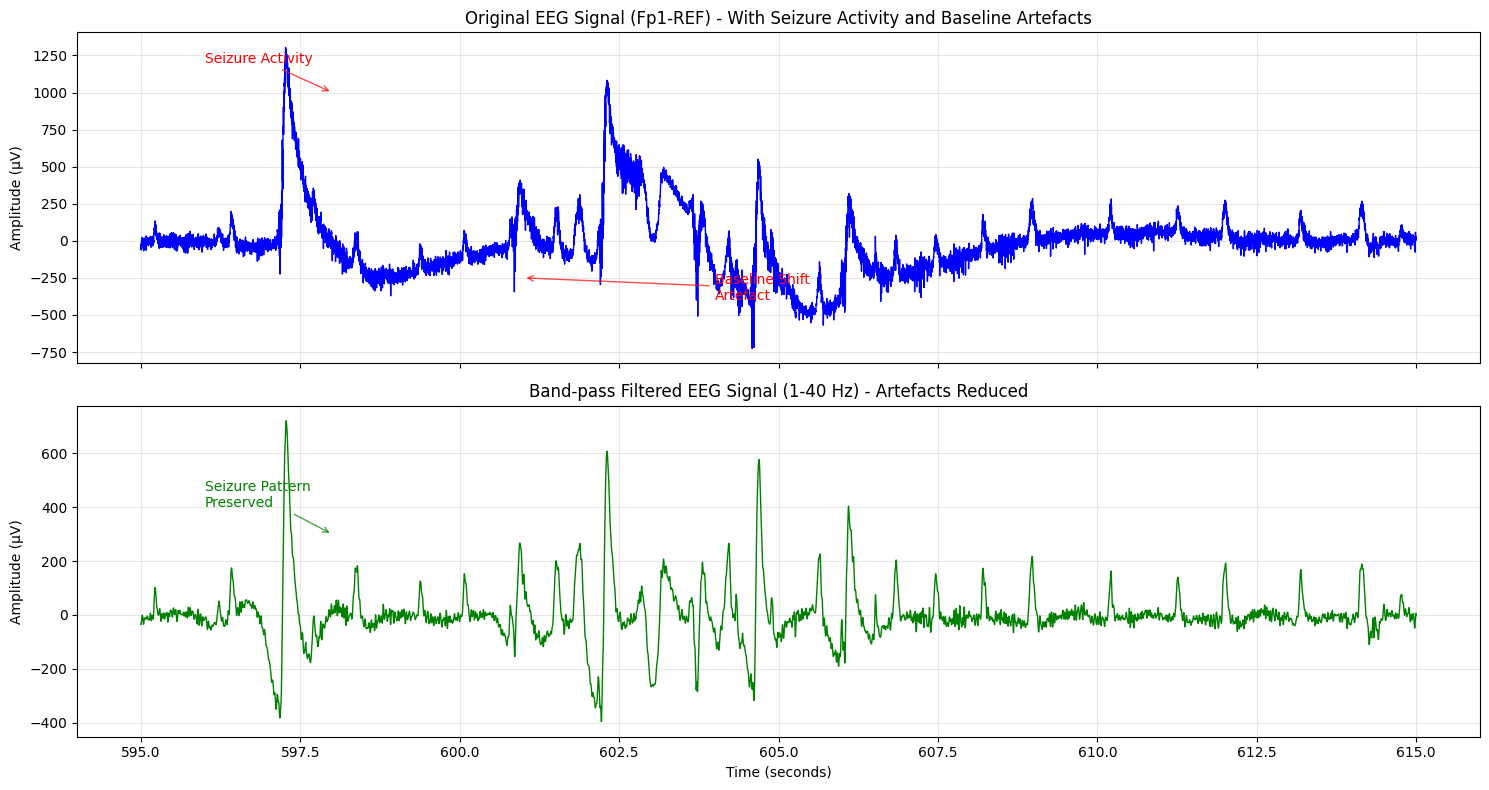

Filter Effects Analysis:
Original signal range: -725.6 to 1304.3 μV
Filtered signal range: -396.3 to 721.2 μV
Seizure amplitude reduction: 1304.3 → 721.2 μV
Baseline correction: Drift from -725.6 μV largely removed


In [ ]:
from scipy import signal

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Apply Butterworth band-pass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

signal_for_analysis = signal_one

# Apply band-pass filter
filtered_signal = apply_bandpass_filter(signal_for_analysis, 1, 40, sample_rate)

start_time = 595.0 
end_time = 615.0  
zoom_start = int(start_time * sample_rate)
zoom_end = int(end_time * sample_rate)
time_zoom = np.arange(zoom_start, zoom_end) / sample_rate

# Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Original signal with artefacts
ax1.plot(time_zoom, signal_for_analysis[zoom_start:zoom_end], 'b-', linewidth=1)
ax1.set_title('Original EEG Signal (Fp1-REF) - With Seizure Activity and Baseline Artefacts')
ax1.set_ylabel('Amplitude (μV)')
ax1.grid(True, alpha=0.3)

# Add annotations for key features
ax1.annotate('Seizure Activity', xy=(598, 1000), xytext=(596, 1200),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
            fontsize=10, color='red')
ax1.annotate('Baseline Shift\nArtefact', xy=(601, -250), xytext=(604, -400),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
            fontsize=10, color='red')

# Filtered signal
ax2.plot(time_zoom, filtered_signal[zoom_start:zoom_end], 'g-', linewidth=1)
ax2.set_title('Band-pass Filtered EEG Signal (1-40 Hz) - Artefacts Reduced')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (μV)')
ax2.grid(True, alpha=0.3)

# Add annotation showing preserved seizure pattern
ax2.annotate('Seizure Pattern\nPreserved', xy=(598, 300), xytext=(596, 400),
            arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
            fontsize=10, color='green')

plt.tight_layout()
plt.show()

# Print comparison statistics
print("Filter Effects Analysis:")
print(f"Original signal range: {np.min(signal_for_analysis[zoom_start:zoom_end]):.1f} to {np.max(signal_for_analysis[zoom_start:zoom_end]):.1f} μV")
print(f"Filtered signal range: {np.min(filtered_signal[zoom_start:zoom_end]):.1f} to {np.max(filtered_signal[zoom_start:zoom_end]):.1f} μV")
print(f"Seizure amplitude reduction: {np.max(signal_for_analysis[zoom_start:zoom_end]):.1f} → {np.max(filtered_signal[zoom_start:zoom_end]):.1f} μV")
print(f"Baseline correction: Drift from {np.min(signal_for_analysis[zoom_start:zoom_end]):.1f} μV largely removed")

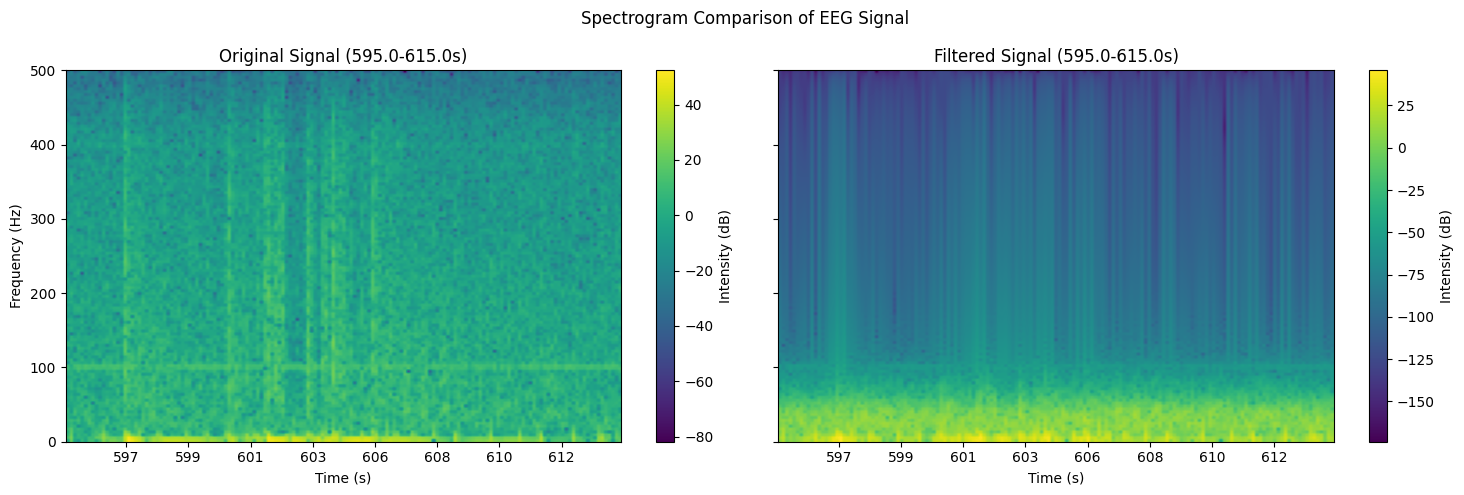

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator, FixedFormatter

start_time = 595.0
end_time = 615.0
zoom_start = int(start_time * sample_rate)
zoom_end = int(end_time * sample_rate)
# Use a slice of the signals to zoom in
zoomed_signal = signal_for_analysis[zoom_start:zoom_end]
zoomed_filtered_signal = filtered_signal[zoom_start:zoom_end]

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot spectrogram for the original signal
spec1 = ax1.specgram(zoomed_signal, Fs=sample_rate)
ax1.set_title(f"Original Signal ({start_time}-{end_time}s)")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Frequency (Hz)")
fig.colorbar(spec1[3], ax=ax1, label="Intensity (dB)")

# Create custom ticks and labels
# The number of ticks is based on the desired interval (e.g., every 5 seconds)
num_ticks = 10
tick_locations = np.linspace(0, end_time - start_time, num_ticks)
tick_labels = np.linspace(start_time, end_time, num_ticks).astype(int)

# Set the custom ticks and labels
ax1.xaxis.set_major_locator(FixedLocator(tick_locations))
ax1.xaxis.set_major_formatter(FixedFormatter(tick_labels))

# Plot spectrogram for the filtered signal
spec2 = ax2.specgram(zoomed_filtered_signal, Fs=sample_rate)
ax2.set_title(f"Filtered Signal ({start_time}-{end_time}s)")
ax2.set_xlabel("Time (s)")
fig.colorbar(spec2[3], ax=ax2, label="Intensity (dB)")

# Apply the same custom ticks and labels to the second subplot
ax2.xaxis.set_major_locator(FixedLocator(tick_locations))
ax2.xaxis.set_major_formatter(FixedFormatter(tick_labels))

fig.suptitle("Spectrogram Comparison of EEG Signal")
plt.tight_layout()
plt.show()

In [22]:
# You will need to install these libraries if you haven't already:
# pip install scikit-learn matplotlib pyedflib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pyedflib

# --- Data Loading and Pre-processing ---
# This section now reads data from all channels of an EDF file.

def read_eeg_data(file_path):
    """Reads an EDF file and returns signal data and metadata."""
    try:
        with pyedflib.EdfReader(file_path) as f:
            # Get all signals and metadata
            signal_labels = f.getSignalLabels()
            sample_rate = f.getSampleFrequency(0)
            signals = [f.readSignal(i) for i in range(len(signal_labels))]
            duration = f.getFileDuration()
        print(f"Successfully loaded {len(signals)} signals from {file_path}")
        return signals, signal_labels, sample_rate, duration
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        # Return empty data to prevent script from crashing
        return [], [], 0, 0

# IMPORTANT: Update the file path to point to your actual data file
path = "seizure_eeg_data/01.edf"
all_signals, signal_labels, sample_rate, duration = read_eeg_data(path)

# You may need to apply the band-pass filter to each signal here before proceeding.
# For example:
# from scipy.signal import butter, lfilter
# b, a = butter(N=4, Wn=[low_cut, high_cut], btype='band', fs=sample_rate)
# filtered_signals = [lfilter(b, a, s) for s in all_signals]
# all_signals = filtered_signals

def create_windows(signal, window_size=256, step_size=128):
    """Create overlapping windows from the signal."""
    signal_length = len(signal)
    num_windows = (signal_length - window_size) // step_size + 1
    windows = np.array([signal[i * step_size:i * step_size + window_size] for i in range(num_windows)])
    return windows

# The function below has been enhanced to include more relevant features.
def compute_features(window_data): 
    """
    Computes a set of features for a single time-series window.
    These features are chosen to be potentially useful for seizure detection.
    """
    if len(window_data) == 0:
        return [0] * 8 # Return a list of zeros for empty windows

    mean_val = np.mean(window_data)
    std_dev = np.std(window_data)
    energy = np.sum(window_data**2)
    
    # Simple frequency-domain features (band power)
    fft_result = np.fft.fft(window_data)
    fft_magnitude = np.abs(fft_result)
    half_length = len(window_data) // 2
    if sample_rate > 0:
        freqs = np.fft.fftfreq(len(window_data), 1/sample_rate)[:half_length]
    else:
        freqs = np.zeros(half_length)
    
    # Define EEG frequency bands (in Hz)
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 12)
    beta_band = (12, 30)
    gamma_band = (30, 70)
    
    def band_power(freqs, fft_magnitude, band_range):
        band_indices = np.where((freqs >= band_range[0]) & (freqs <= band_range[1]))[0]
        return np.sum(fft_magnitude[band_indices]**2)

    delta_power = band_power(freqs, fft_magnitude, delta_band)
    theta_power = band_power(freqs, fft_magnitude, theta_band)
    alpha_power = band_power(freqs, fft_magnitude, alpha_band)
    beta_power = band_power(freqs, fft_magnitude, beta_band)
    gamma_power = band_power(freqs, fft_magnitude, gamma_band)

    return [mean_val, std_dev, energy, delta_power, theta_power, alpha_power, beta_power, gamma_power]

# --- Main Part 3.3 Code ---

# Create windows for each channel and compute features
# **Report:** Part 3.3 - Description of Windows and Features
if all_signals:
    windows_per_channel = [create_windows(s) for s in all_signals]
    
    num_windows = len(windows_per_channel[0])
    num_channels = len(all_signals)
    
    print(f"Created {num_windows} windows for each of the {num_channels} channels.")
    
    # Now, combine the features from all channels for each time window
    X = np.zeros((num_windows, num_channels * 8)) # 8 features per channel
    
    for i in range(num_windows):
        feature_vector_for_window = []
        for j in range(num_channels):
            features = compute_features(windows_per_channel[j][i])
            feature_vector_for_window.extend(features)
        X[i] = feature_vector_for_window
    
    print(f"Final feature matrix shape: {X.shape}")
else:
    X = np.array([])
    num_windows = 0
    print("No signals loaded, skipping feature extraction.")


# --- IMPORTANT: MOCK LABELS FOR DEMONSTRATION ---
# You must replace this with your actual labels (seizure vs. non-seizure).
# These mock labels are just to make the code runnable and show the process.
if num_windows > 0:
    y = np.zeros(num_windows, dtype=int)
    seizure_start = int(num_windows * 0.4)
    seizure_end = int(num_windows * 0.6)
    y[seizure_start:seizure_end] = 1
    print(f"Total number of windows: {len(y)}")
    print(f"Number of seizure windows (1): {np.sum(y)}")
    print(f"Number of non-seizure windows (0): {len(y) - np.sum(y)}")
else:
    y = np.array([])
    print("No labels created as no windows were generated.")


# **Report:** Part 3.3 - Description of Data Split
# Split the data into training and test sets
if len(X) > 0 and len(y) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # --- Baseline Decoder Evaluation ---
    # **Report:** Part 3.3 - Baseline Evaluation
    print("\n--- Baseline Decoder Evaluation ---")

    decoder_baseline = LogisticRegression(solver='liblinear')
    decoder_baseline.fit(X_train, y_train)
    y_pred_baseline = decoder_baseline.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_baseline))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_baseline))
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.2f}")


    # --- Investigation 1: Balancing the Data ---
    # **Report:** Part 3.3 - Effect of Balancing
    print("\n\n--- Investigation 1: Effect of Balancing (Manual Oversampling) ---")

    # Find the indices of the minority (seizure) and majority (non-seizure) classes
    minority_indices = np.where(y_train == 1)[0]
    majority_indices = np.where(y_train == 0)[0]

    # Oversample the minority class to match the number of majority class samples
    oversampled_indices = np.random.choice(minority_indices, len(majority_indices), replace=True)

    # Create the new balanced training set
    X_train_balanced = np.vstack([X_train[majority_indices], X_train[oversampled_indices]])
    y_train_balanced = np.concatenate([y_train[majority_indices], y_train[oversampled_indices]])

    print(f"Original training set size: {len(X_train)}")
    print(f"Balanced training set size: {len(X_train_balanced)}")
    print("Label counts in balanced training set:", np.unique(y_train_balanced, return_counts=True))

    decoder_balanced = LogisticRegression(solver='liblinear')
    decoder_balanced.fit(X_train_balanced, y_train_balanced)
    y_pred_balanced = decoder_balanced.predict(X_test)

    print("\nClassification Report (Balanced):")
    print(classification_report(y_test, y_pred_balanced))
    print("\nConfusion Matrix (Balanced):")
    print(confusion_matrix(y_test, y_pred_balanced))


    # --- Investigation 2: Scaling the Features ---
    # **Report:** Part 3.3 - Effect of Scaling
    print("\n\n--- Investigation 2: Effect of Scaling ---")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    decoder_scaled = LogisticRegression(solver='liblinear', max_iter=1000)
    decoder_scaled.fit(X_train_scaled, y_train)
    y_pred_scaled = decoder_scaled.predict(X_test_scaled)

    print("\nClassification Report (Scaled):")
    print(classification_report(y_test, y_pred_scaled))
    print("\nConfusion Matrix (Scaled):")
    print(confusion_matrix(y_test, y_pred_scaled))
else:
    print("\n--- Skipping evaluations as no data was loaded or processed ---")


# --- Part 3.3 - Reasoning ---
# Use this space to write down your reasoning as requested in the task.
# "Why would feature selection and k-fold cross-validation be a good choice for a real investigation?"
#
# Your Answer:
"""
Reasoning for Feature Selection and K-Fold Cross-Validation:

- Feature Selection: In a real-world scenario, you might compute dozens or even hundreds of features for each window. Not all of these features are equally useful for seizure detection; some may even be redundant or add noise. Feature selection helps to identify and use only the most informative features, which can lead to a simpler model, faster training times, and often better generalization performance on new data. It helps to avoid overfitting, where the model learns the noise in the data rather than the underlying pattern.

- K-Fold Cross-Validation: This is a more robust way to evaluate a model's performance than a single train/test split. In a real investigation, a single split can be misleading, as the performance might heavily depend on which specific data points ended up in the training set and which ended up in the test set. K-fold cross-validation involves splitting the data into 'k' folds, training the model 'k' times (each time using a different fold as the test set), and then averaging the results. This gives a more reliable and less biased estimate of the model's true performance.
"""


Successfully loaded 28 signals from seizure_eeg_data/01.edf
Created 28147 windows for each of the 28 channels.
Final feature matrix shape: (28147, 224)
Total number of windows: 28147
Number of seizure windows (1): 5630
Number of non-seizure windows (0): 22517

--- Baseline Decoder Evaluation ---


/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6743
           1       0.81      0.81      0.81      1702

    accuracy                           0.93      8445
   macro avg       0.88      0.88      0.88      8445
weighted avg       0.93      0.93      0.93      8445


Confusion Matrix:
[[6425  318]
 [ 315 1387]]

Accuracy: 0.93


--- Investigation 1: Effect of Balancing (Manual Oversampling) ---
Original training set size: 19702
Balanced training set size: 31548
Label counts in balanced training set: (array([0, 1]), array([15774, 15774]))


/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      6743
           1       0.71      0.93      0.81      1702

    accuracy                           0.91      8445
   macro avg       0.85      0.92      0.88      8445
weighted avg       0.93      0.91      0.92      8445


Confusion Matrix (Balanced):
[[6107  636]
 [ 113 1589]]


--- Investigation 2: Effect of Scaling ---

Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6743
           1       0.91      0.89      0.90      1702

    accuracy                           0.96      8445
   macro avg       0.94      0.93      0.94      8445
weighted avg       0.96      0.96      0.96      8445


Confusion Matrix (Scaled):
[[6584  159]
 [ 186 1516]]


/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


"\nReasoning for Feature Selection and K-Fold Cross-Validation:\n\n- Feature Selection: In a real-world scenario, you might compute dozens or even hundreds of features for each window. Not all of these features are equally useful for seizure detection; some may even be redundant or add noise. Feature selection helps to identify and use only the most informative features, which can lead to a simpler model, faster training times, and often better generalization performance on new data. It helps to avoid overfitting, where the model learns the noise in the data rather than the underlying pattern.\n\n- K-Fold Cross-Validation: This is a more robust way to evaluate a model's performance than a single train/test split. In a real investigation, a single split can be misleading, as the performance might heavily depend on which specific data points ended up in the training set and which ended up in the test set. K-fold cross-validation involves splitting the data into 'k' folds, training the mo